# Numerous pre-trained models are readily available at https://huggingface.co/

## Image classification using ResNet

Dimensioni del tensore: torch.Size([1, 3, 224, 224])
Predicted Label:  281 corresponding to the Class:  tabby, tabby cat


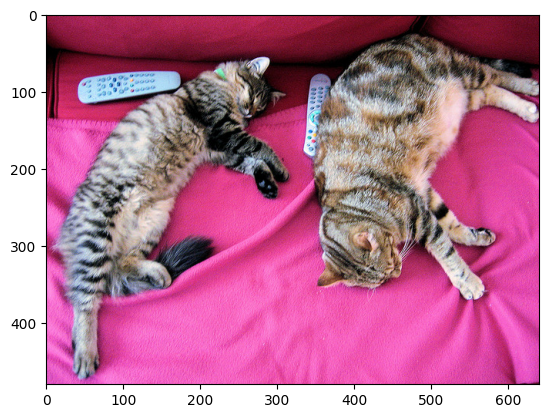

In [7]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

trust_remote_code=True

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

plt.imshow(image)

# Preprocessing via "AutoFeatureExtractor":
# -Ridimensionamento dell'immagine: Porta l'immagine a una dimensione fissa richiesta dal modello (es. 224x224 per Vision Transformer).
# - Normalizzazione dei valori di pixel: Converte i valori di pixel (che spesso sono in un intervallo tra 0 e 255) a un intervallo tra 0 e 1 o a una distribuzione standardizzata con una media e una deviazione standard specifica.
# - Riorganizzazione delle dimensioni: Rende l'immagine compatibile con i modelli deep learning, organizzando le dimensioni come [batch_size, channels, height, width].
# -Conversione in tensore: Converte l'immagine in un tensore (ad esempio, un torch.Tensor se stai usando PyTorch) per poter essere elaborata dal modello.
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-101")
inputs = feature_extractor(image, return_tensors="pt")

model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-101")

# Checkpoint: 
# Accedi ai dati contenuti in "inputs"
data = inputs.data
dimensions = data['pixel_values'].shape
print("Dimensioni del tensore:", dimensions)

#Valutazione
with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()

print("Predicted Label: ", predicted_label, "corresponding to the Class: ", model.config.id2label[predicted_label])

## EXERCISE 1: 

test the classification model on a dataset (e.g. https://huggingface.co/datasets/Bingsu/Cat_and_Dog) and return the performance in term of recognition rate 


In [8]:
#TO DO

### SOLUZIONE:

In [9]:
def compute_accuracy(predictions, labels, negative_preds=0):
    positives = sum(predictions == labels)
    negatives = sum(predictions != labels) + negative_preds
    return positives / (positives + negatives)

# Funzione per mappare le predizioni in binario
def map_predictions(preds):
    # Definiamo gli indici di ImageNet per "gatti" e "cani" (da https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)
    cat_indices = list(range(281, 285))  # Indici per gatti in ImageNet
    dog_indices = list(range(151,275))   # Indici per cani in ImageNet
    
    binary_preds = []
    for p in preds:
        if p in cat_indices:
            binary_preds.append(0)  # Mappiamo i "gatti" a 0
        elif p in dog_indices:
            binary_preds.append(1)  # Mappiamo i "cani" a 1
        else:
            binary_preds.append(-1)  # Ignoriamo altre classi (se presenti)
    return binary_preds

# Funzione di valutazione
def evaluate_model(model, feature_extractor, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    for sample in tqdm(dataset):
        # Preprocessamento dell'immagine
        inputs = feature_extractor(images=sample["image"], return_tensors="pt").to(device)
        labels = torch.tensor([sample["label"]]).to(device)
        
        # Predizione
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            pred = torch.argmax(logits, dim=-1).cpu().numpy()
        
        # Aggiungiamo la predizione e l'etichetta
        all_preds.extend(pred)
        all_labels.extend(labels.cpu().numpy())
    
    # Mappiamo le predizioni per classificare solo gatti e cani
    mapped_preds = map_predictions(all_preds)
    
    negative_preds = np.sum(np.array(mapped_preds) == -1)
    
    # Filtriamo le predizioni valide (rimuovendo quelle con -1) e le etichette corrispondenti
    valid_indices = [i for i, p in enumerate(mapped_preds) if p != -1]
    valid_preds = np.array(mapped_preds)[valid_indices]
    valid_labels = np.array(all_labels)[valid_indices]

    # Calcoliamo l'accuratezza
    accuracy = compute_accuracy(valid_preds, valid_labels, negative_preds)
    return accuracy

In [10]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

#Carichiamo solo n test images 
dataset = load_dataset("Bingsu/Cat_and_Dog", split="test[:10]")  # Prendiamo solo i primi 100 elementi
dataset = dataset.map(lambda x: {"label": int(x["labels"] == "dog")})  # Trasformiamo le etichette in 0 (cat) o 1 (dog)

# Carica il modello ResNet e l'estrattore di caratteristiche
resnet_model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-101")
resnet_feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-101")

accuracy = evaluate_model(resnet_model, resnet_feature_extractor, dataset)

print(f"Accuracy: {accuracy * 100:.2f}%")


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

Accuracy: 60.00%


## Object Detection

Detected remote with confidence 0.991 at location [46.48, 72.78, 178.98, 119.3]
Detected remote with confidence 0.908 at location [336.48, 79.27, 368.23, 192.36]
Detected cat with confidence 0.934 at location [337.18, 18.06, 638.14, 373.09]
Detected cat with confidence 0.979 at location [10.93, 53.74, 313.41, 470.67]
Detected remote with confidence 0.974 at location [41.63, 72.23, 178.09, 119.99]


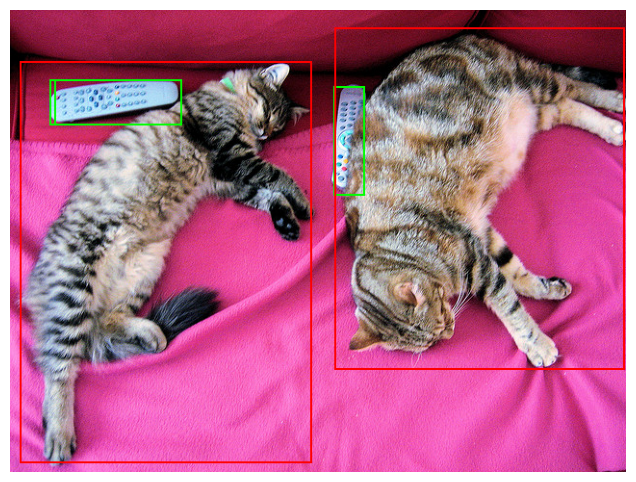

In [11]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image, ImageDraw, ImageFont
import torch
import requests
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Prepare the image for plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner plot

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

# print results
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )


# Process outputs and draw boxes
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image)

color_map = {'cat': (255, 0, 0), 'remote': (0, 255, 0)}  # Define colors for different classes

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    
    if score.item() < 0.9:  # Optionally, filter out detections with low confidence
        continue

    box = [round(i, 2) for i in box.tolist()]
    x_min, y_min, x_max, y_max = box

    # Get the color for the current class label
    color = color_map.get(model.config.id2label[label.item()], (0, 0, 255))  # Default color for unknown classes

    # Draw bounding box with label and confidence score
    draw.rectangle(((x_min, y_min), (x_max, y_max)), outline=color, width=2)
    
     
# Display the final image with boxes
plt.imshow(image)
plt.axis('off')
plt.show()

Output could be enriched adding the label and the confidence for each detected object

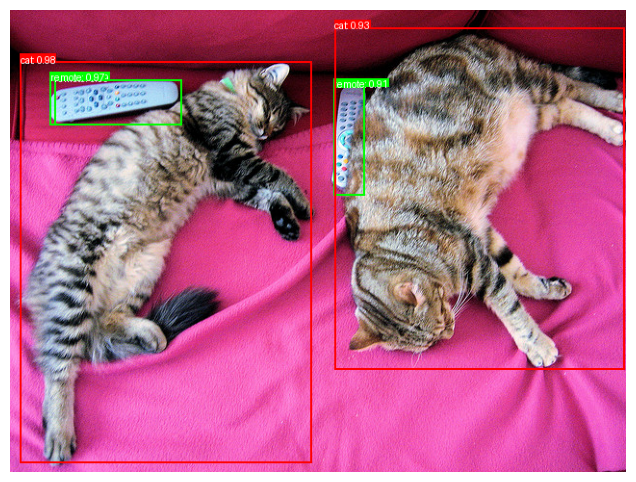

In [12]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image, ImageDraw, ImageFont
import torch
import requests
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Prepare the image for plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner plot

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Process outputs and draw boxes
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image)

# Define colors for different classes (here only cat and remote which are present in the image)
color_map = {'cat': (255, 0, 0), 'remote': (0, 255, 0)}  # Example color map

# Define font for labels
try:
    font = ImageFont.truetype("arial.ttf", 16)
except IOError:
    font = ImageFont.load_default()

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    
    if score.item() < 0.9:  # Optionally, filter out detections with low confidence
        continue

    box = [round(i, 2) for i in box.tolist()]
    x_min, y_min, x_max, y_max = box

    # Get the color for the current class label
    color = color_map.get(model.config.id2label[label.item()], (0, 0, 255))  # Default color for unknown classes

    # Draw bounding box
    draw.rectangle(((x_min, y_min), (x_max, y_max)), outline=color, width=2)

    # Draw label and confidence score
    label_text = f"{model.config.id2label[label.item()]}: {round(score.item(), 2)}"
    
    # Calculate text size using textbbox
    text_bbox = draw.textbbox((0, 0), label_text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    text_background = (x_min, y_min - text_height, x_min + text_width, y_min)
    draw.rectangle(text_background, fill=color)  # Background for text
    draw.text((x_min, y_min - text_height), label_text, fill="white", font=font)

# Display the final image with boxes, labels, and confidence scores
plt.imshow(image)
plt.axis('off')
plt.show() 

### EXERCISE 2: 

test the model with your own images.